## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Step 1: Compute the camera calibration using chessboard images

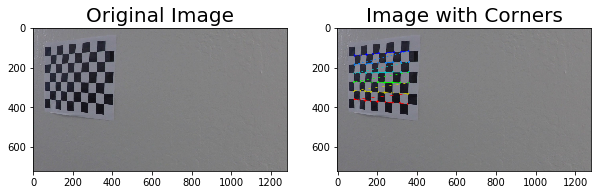

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import glob

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints=[] #3D points in real space 
imgpoints=[] #2D points in img space

#Image list
images = glob.glob('../camera_cal/calibration*.jpg')

fig, axes= plt.subplots(1,2,figsize=(10,10))
for image in images:
    img = mpimg.imread(image)
    i = 0
    #converting to Grayscale before finding Chessboard Corners
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

   # if(i==0 ):
        # Plotting the original Image
    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=20)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    i = i+1
    if(ret==True):
        objpoints.append(objp)
        imgpoints.append(corners)

        # Drawing Chessboard Corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        axes[1].set_title('Image with Corners', fontsize=20)

**Undistorted chessboard image**

Text(0.5,1,'Undistorted Image')

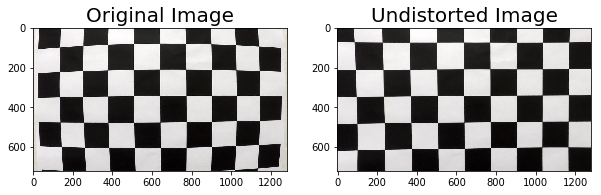

In [12]:
img = mpimg.imread('../camera_cal/calibration1.jpg')
#img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig, axes= plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=20)
axes[1].imshow(dst)
axes[1].set_title("Undistorted Image", fontsize=20)

### Step 2: Undistort the Raw images

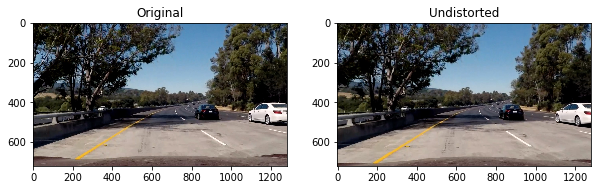

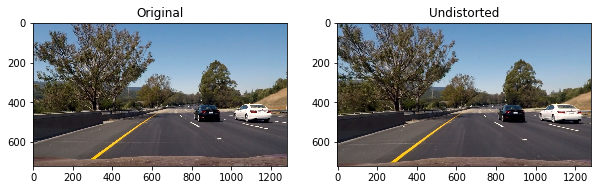

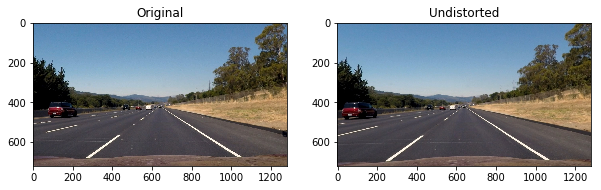

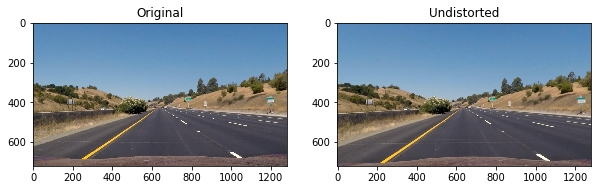

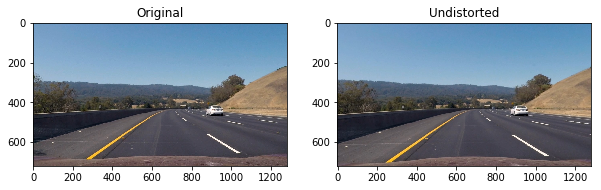

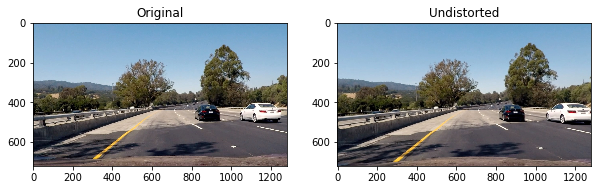

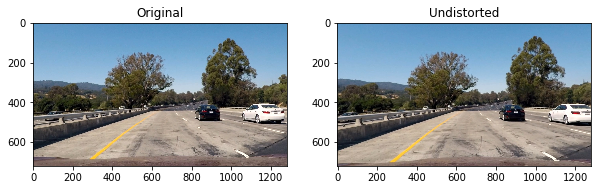

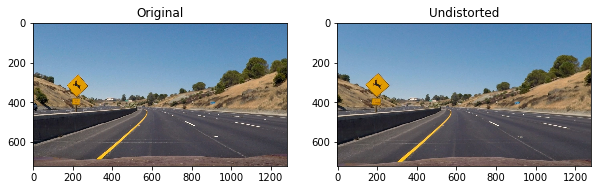

In [13]:
images = glob.glob('../test_images/*.jpg') 
original = []

for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    original.append(originalImage)
    fig, axes= plt.subplots(1,2,figsize=(10,10))

    axes[0].imshow(originalImage)
    axes[0].set_title("Original")
    undistortedImg = cv2.undistort(originalImage, mtx, dist, None, mtx) # undistorting image 
    axes[1].set_title("Undistorted")
    axes[1].imshow(undistortedImg)

### Step 3: Apply a perspective transform to rectify binary image ("birds-eye view")

In [14]:
src=np.float32([[150,720],[590,450],[700,450],[1250,720]]) # Source Points for Image Warp
dst= np.float32([[200 ,720], [200  ,0], [980 ,0], [980 ,720]]) # Destination Points for Image Warp

def WarpPerspective(image):
    img_size = (image.shape[1],image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

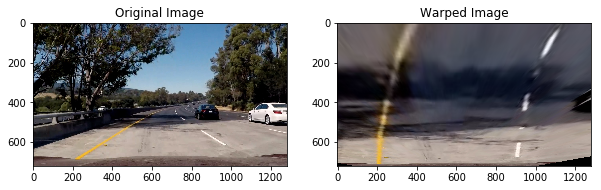

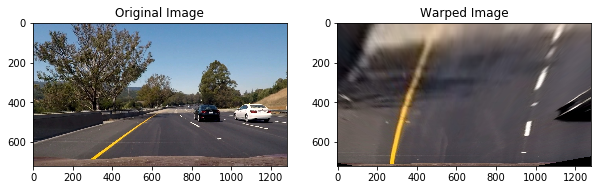

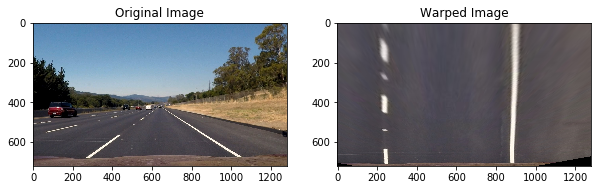

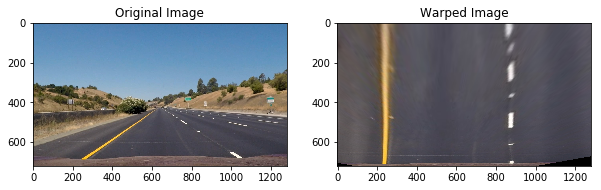

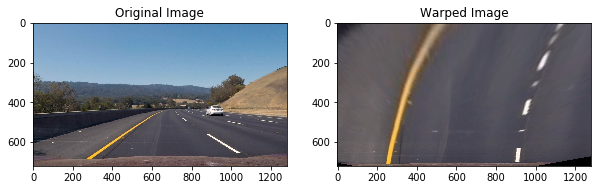

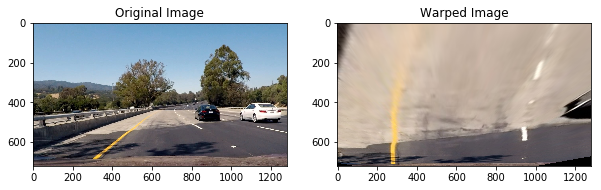

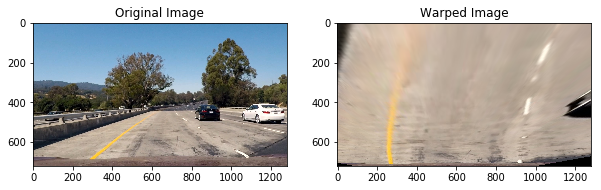

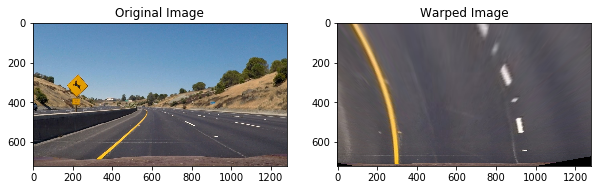

In [15]:
warpedImages=[]
for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    untouchedImage= originalImage.copy()
    fig, axes= plt.subplots(1,2,figsize=(10,10))

    axes[0].imshow(originalImage)
    axes[0].set_title("Original Image")
    y=untouchedImage.shape[0]
    x=untouchedImage.shape[1]
    warped = WarpPerspective(untouchedImage)
    warpedImages.append(warped)
    axes[1].imshow(warped)
    axes[1].set_title("Warped Image")

### Step 4: Use color transforms and gradients to create a thresholded binary image

In [16]:
#A function to extract a specific color channel 
def undistortImage(image):
    return cv2.undistort(image, mtx, dist, None, mtx)
def ExtractChannel(image,colorspace,threshold,channel=0):
    colorspace = cv2.cvtColor(image, colorspace)
    extracted_channel = colorspace[:,:,channel]
    binary = np.zeros_like(extracted_channel)
    binary[(extracted_channel >= threshold[0]) & (extracted_channel <= threshold[1])] = 1
    return binary

Text(0.5,1,'S')

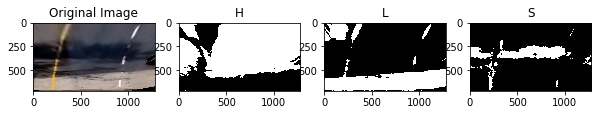

In [18]:
# Testing Color Spaces on Test Images
fig, axes= plt.subplots(1,4,figsize=(10,10))

image=warpedImages[0]

threshold= [100,255]

axes[0].imshow(image)
axes[0].set_title("Original Image")

# HLS Colorspace
h=ExtractChannel(image, cv2.COLOR_RGB2HLS ,threshold,0)
axes[1].imshow(h,cmap='gray')
axes[1].set_title("H")

l=ExtractChannel(image, cv2.COLOR_RGB2HLS ,threshold,1)
axes[2].imshow(l,cmap='gray')
axes[2].set_title("L")

s=ExtractChannel(image, cv2.COLOR_RGB2HLS ,threshold,2)
axes[3].imshow(s,cmap='gray')
axes[3].set_title("S")

**Computing gradients**

In [19]:
def Sobel(warpedimage, threshold, sobelType, kernelSize=3):
    
    #Converting to gray scale
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY) 
    
    #Getting gradient in x and y directions respectively.
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=kernelSize)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=kernelSize)
    
    #Magnitude of gradiennt in x direction
    abs_sobelx = np.absolute(sobelx)
    #Magnitude of gradiennt in y direction
    abs_sobely = np.absolute(sobely)
    
    #Magnitude of gradient in xy
    grad= np.sqrt(sobelx**2 + sobely**2)
    
    #Direction of gradient
    direction = np.arctan2(abs_sobely,abs_sobelx)
    
    valParam=abs_sobelx
    
    if(sobelType=='x'):
        res = abs_sobelx
    elif(sobelType=='y'):
        res = abs_sobely
    elif(sobelType=='xy'):
        res = grad
    else:
        res = direction
        
    # Normalizing the sobel image
    img = np.uint8((res* 255)/np.max(res)) 
    binary_output = np.zeros_like(img)
    binary_output[(img > threshold[0]) & (img < threshold[1])]=1
    return binary_output

Text(0.5,1,'Sobel Direction')

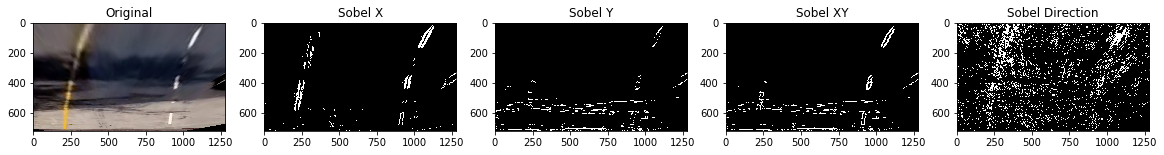

In [20]:
# Checking which gradient looks better
fig, axes= plt.subplots(1,5,figsize=(20,8))

threshold=[20,100]
img= images[0]
img= cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)

axes[0].imshow(image)
axes[0].set_title("Original")

sobelx=Sobel(image,threshold,'x')
axes[1].imshow(sobelx, cmap = 'gray')
axes[1].set_title("Sobel X")

sobely=Sobel(image,threshold,'y')
axes[2].imshow(sobely, cmap = 'gray')
axes[2].set_title("Sobel Y")

sobelxy=Sobel(image,threshold,'xy')
axes[3].imshow(sobelxy, cmap = 'gray')
axes[3].set_title("Sobel XY")

sobeldir=Sobel(image,threshold,'dir')
axes[4].imshow(sobeldir, cmap = 'gray')
axes[4].set_title("Sobel Direction")


**Final threshold binary image after combining all selected thresholds**

In [24]:
def combined(warpedImage, color_threshold, sobel_threshold):
    
    s_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,2)
    l_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,1)
    y_channel= ExtractChannel(warpedImage,cv2.COLOR_RGB2YUV,color_threshold,0)
    
    sobelx = Sobel(warpedImage, sobel_threshold, 'x')
    sobeldir= Sobel(warpedImage, [0.7,25], 'dir')
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(((s_channel == 1) & (l_channel==1)) & (y_channel==1)) | (sobelx == 1)  ] = 1
    return combined_binary

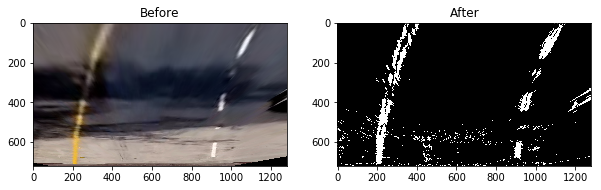

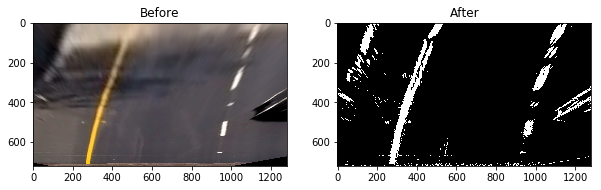

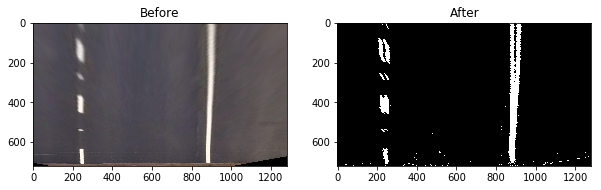

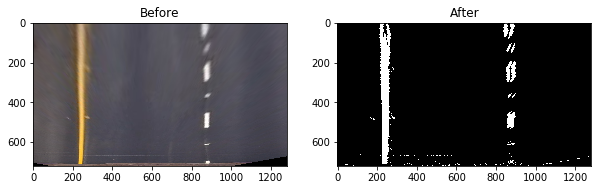

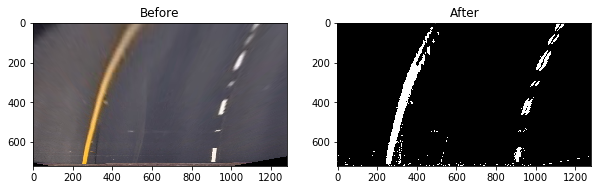

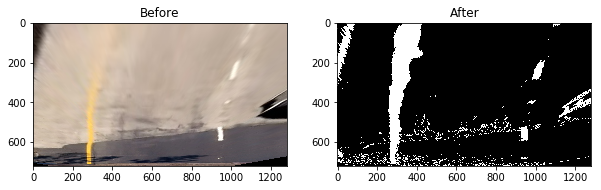

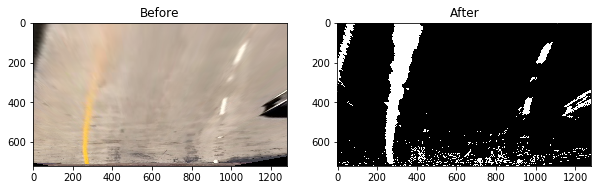

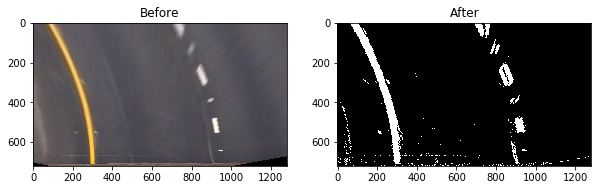

In [26]:
#Testing
for index,warped in enumerate(warpedImages):
    combinedImage=combined(warped,[100,255],[10,150])
    fig, axes= plt.subplots(1,2,figsize=(10,10))
    axes[0].imshow(warped)
    axes[0].set_title("Before")
    axes[1].imshow(combinedImage,cmap='gray')
    axes[1].set_title("After")

Text(0.5,1,'Histogram')

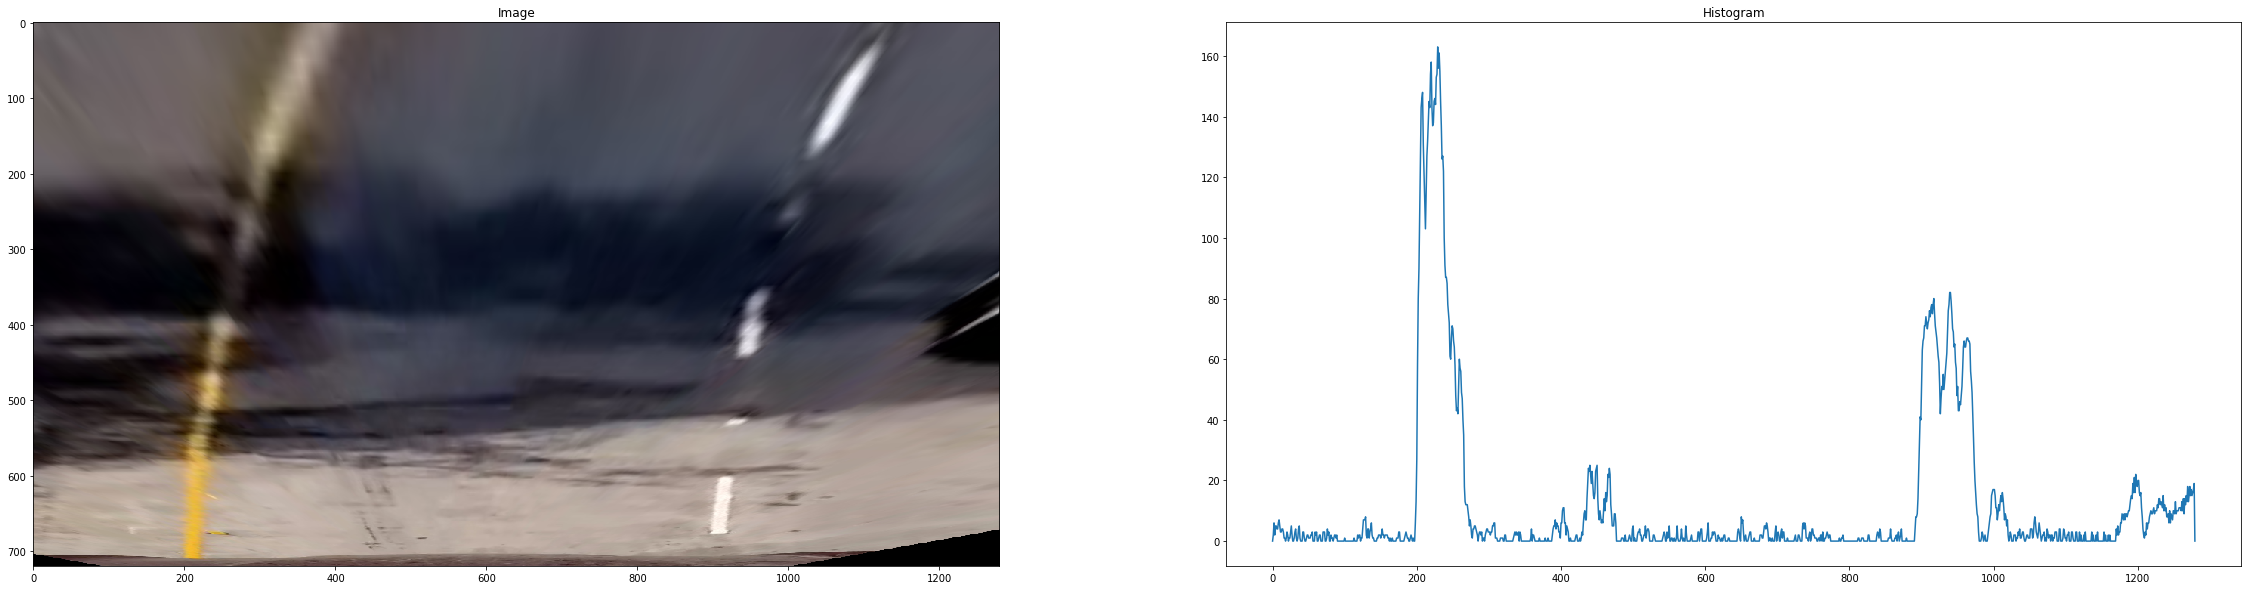

In [29]:
# Plotting Histogram
def Histogram(warpedimage):
    return np.sum(warpedimage[warpedimage.shape[0]//2:,:], axis=0)
# Testing
fig, axes= plt.subplots(1,2,figsize=(40,10))
img= warpedImages[0]
axes[0].imshow(img)
axes[0].set_title("Image")
combinedImage=combined(img,[150,255],[20,100])
histogram = Histogram(combinedImage)
axes[1].plot(histogram)
axes[1].set_title("Histogram")


### Step 5: Detect lane pixels and fit to find the lane boundary

In [30]:
def SlidingWindowSearch(binary, plot=False):

    histogram = Histogram(binary)
    
    # Create an output image to draw on
    out_img = np.dstack((binary, binary, binary))*255
    
    # Find the peak of the left and right halves of the histogram which will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    n = 9
    
    # Height of windows
    window_height = np.int(binary.shape[0]/n) 
    
    # Identify the x and y positions of all nonzero pixels
    nonzero = binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    # Width of the windows +/- margin
    margin = 100
    
    # Minimum number of pixels found to recenter window
    min_pixels = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane = []
    right_lane = []

    # Step through the windows one by one
    for window in range(n):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_x_left_low = left_x_current - margin
        win_x_left_high = left_x_current + margin
        win_x_right_low = right_x_current - margin
        win_x_right_high = right_x_current + margin
        
        # Draw the windows on the visualization image
        if(plot==True):
            cv2.rectangle(out_img,(win_x_left_low,win_y_low),(win_x_left_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_x_right_low,win_y_low),(win_x_right_high,win_y_high),(0,255,0), 2) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & 
        (nonzero_x >= win_x_left_low) &  (nonzero_x < win_x_left_high)).nonzero()[0]
        good_right = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & 
        (nonzero_x >= win_x_right_low) &  (nonzero_x < win_x_right_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane.append(good_left)
        right_lane.append(good_right)
        
        # If you found > min_pixels pixels, recenter next window on their mean position
        if len(good_left) > min_pixels:
            left_x_current = np.int(np.mean(nonzero_x[good_left]))
        if len(good_right) > min_pixels:        
            right_x_current = np.int(np.mean(nonzero_x[good_right]))

    # Concatenate the arrays of indices
    left_lane = np.concatenate(left_lane)
    right_lane = np.concatenate(right_lane)

    # Extract left and right line pixel positions
    left_x = nonzero_x[left_lane]
    left_y = nonzero_y[left_lane] 
    right_x = nonzero_x[right_lane]
    right_y = nonzero_y[right_lane] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    return left_fit,right_fit,left_lane,right_lane,out_img


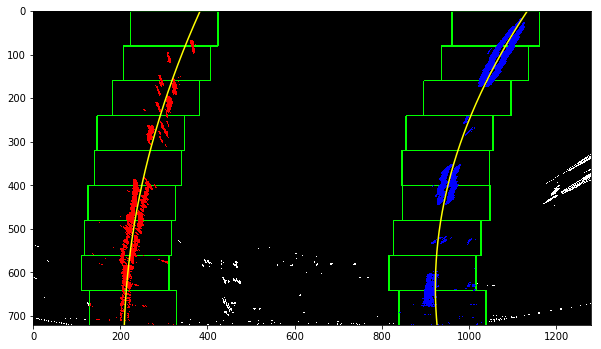

In [31]:
def VisualizeSlidingWindow(binary, left_fit,right_fit, left_lane, right_lane,out_img):
    nonzero = binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [255, 0, 0]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [0, 0, 255]
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure(figsize=(10,10))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
  
l,r,ld,rd,o=SlidingWindowSearch(combinedImage, plot=True)
VisualizeSlidingWindow(combinedImage,l,r,ld,rd,o)


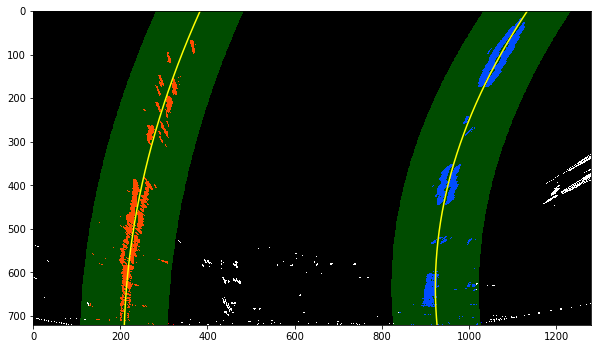

In [35]:
def VisualizeLaneDetection(binary, left_fit,right_fit, left_lane, right_lane,out_img):
    margin = 100
    nonzero = binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [255, 0, 0]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [0, 0, 255]
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    
 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary, binary, binary))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [255, 0, 0]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    
    plt.figure(figsize=(10,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

l,r,ld,rd,o=SlidingWindowSearch(combinedImage, plot=False)
VisualizeLaneDetection(combinedImage,l,r,ld,rd,o)


### Step 6: Warp the detected lane boundaries back onto the original image

In [32]:
#Plot line on the unwarped image

def DrawLine(original_image,binary, left_fit, right_fit):
    
    h,w= binary.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    zeros = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((zeros, zeros, zeros))
    
   
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #axes[index+1].imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result


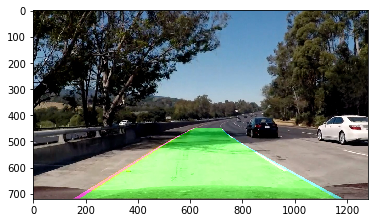

In [41]:
originalImage= images[0]
originalImage=cv2.cvtColor(cv2.imread(originalImage), cv2.COLOR_BGR2RGB)
returnedOutput =  SlidingWindowSearch(combinedImage)
left_fit=returnedOutput[0]
right_fit=returnedOutput[1]
finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
plt.imshow(finalImage)

### Step 7: Determine the curvature of the lane and vehicle position with respect to center

In [33]:
def CalculateRadiusOfCurvature(binary,left_fit,right_fit):
    ym = 30/720 # meters per pixel in y dimension
    xm = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    car_position= binary.shape[1]/2
    
    # Fit new polynomials to x,y 
    left_fit_cr = np.polyfit(ploty*ym, leftx*xm, 2)
    right_fit_cr = np.polyfit(ploty*ym, rightx*xm, 2)
    
    # Calculate the new radius of curvature
    y_eval=np.max(ploty)
    
    left_curve_radius = ((1 + (2*left_fit_cr[0]*y_eval*ym + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_radius = ((1 + (2*right_fit_cr[0]*y_eval*ym + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actual_position= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (car_position - actual_position)* xm
    
    return (left_curve_radius + right_curve_radius)/2, distance

In [52]:
from random import randint
import datetime
import time

def pipeline(originalImage):
    originalImage= cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
    undistortedImage= undistortImage(originalImage)
    warpedImage= WarpPerspective(undistortedImage)
    combinedImage= combined(warpedImage,color_threshold= [100,255],sobel_threshold=[10,150])
    returnedOutput =  SlidingWindowSearch(combinedImage)
    left_fit=returnedOutput[0]
    right_fit=returnedOutput[1]
    
    finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
       
    radius, distance = CalculateRadiusOfCurvature(combinedImage,left_fit,right_fit)
    cv2.putText(finalImage,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,255),4)
    
    if distance > 0:
        cv2.putText(finalImage,"Vehicle is {:2f}".format(distance)+ "m right of center", (100,150), 2, 1, (0,255,255),4)
    else:
         cv2.putText(finalImage,"Vehicle is {:2f}".format(-1*distance)+ "m left of center", (100,150), 2, 1, (0,255,255),4)
            
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d %H%M%S')
        
    cv2.imwrite('./Output_1/'+str(st)+'.jpg',originalImage)
    
    cv2.imwrite('./Output_1/'+str(st)+'_o.jpg',finalImage)
    newCombinedImage= np.dstack((combinedImage*255,combinedImage*255,combinedImage*255))
    finalImage[100:240,1000:1200, :]= cv2.resize(newCombinedImage, (200,140))
    return cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)
    

### Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

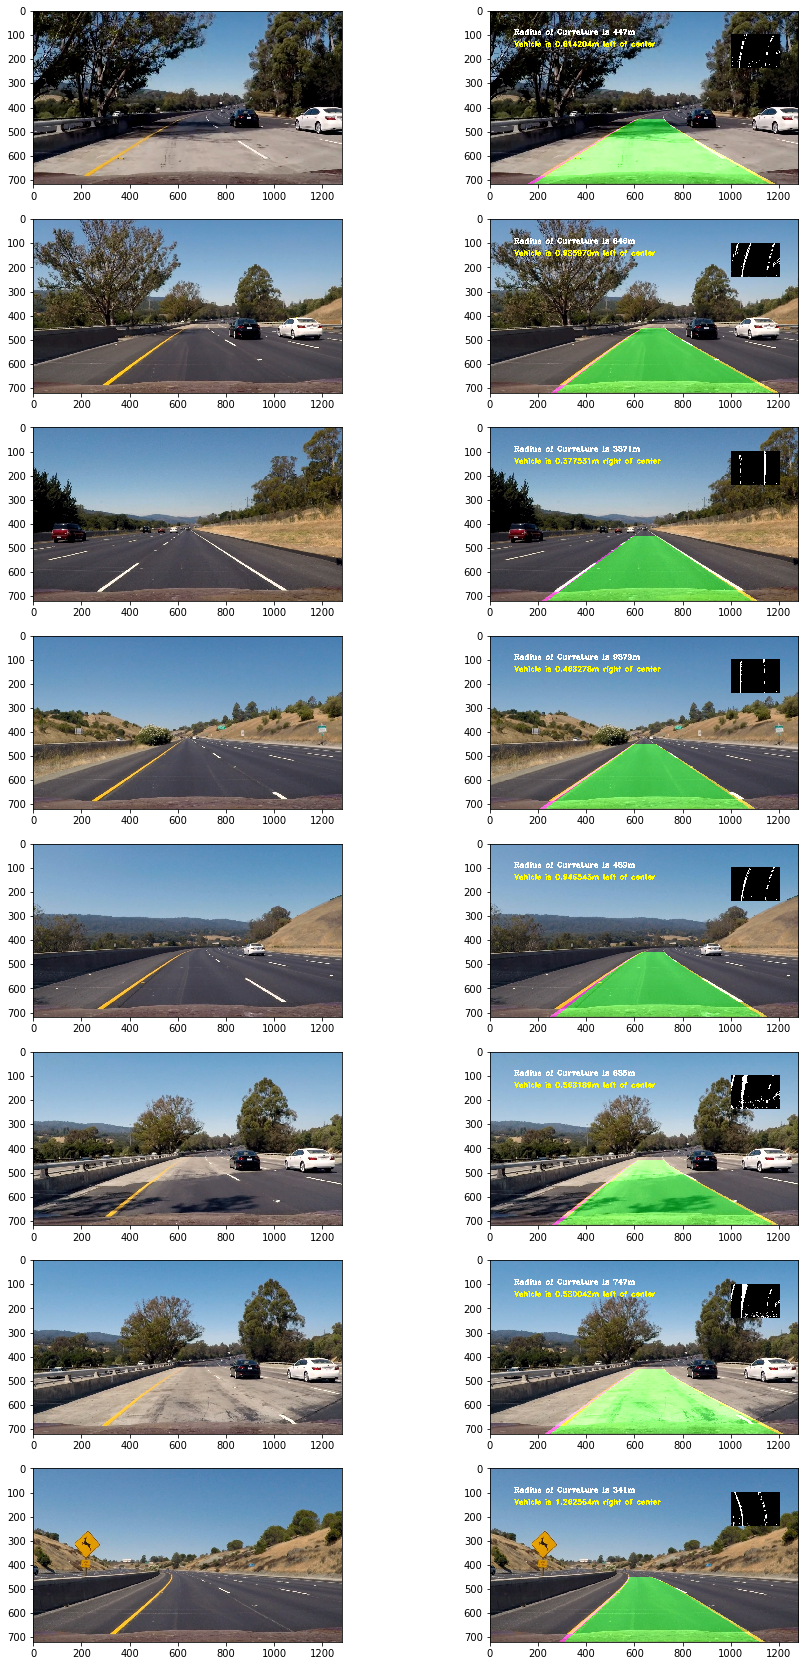

In [51]:
fig, axes= plt.subplots(8,2,figsize=(15,30))

images = glob.glob('../test_images/*.jpg') # Reading Images from test_images folder

for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    finalImage=pipeline(originalImage)
    cv2.imwrite('output_images/'+str(index)+'.jpg', cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(originalImage)
    axes[index,1].imshow(finalImage)

In [53]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('../project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:48<00:00,  2.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 8s, sys: 29.1 s, total: 4min 37s
Wall time: 6min 51s


In [54]:
myclip = VideoFileClip("project_video_output.mp4")
myclip.write_gif("test.gif")


[MoviePy] Building file test.gif with imageio


100%|█████████▉| 1260/1261 [07:17<00:00,  3.05it/s]


In [55]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('../challenge_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:34<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 32s, sys: 17.5 s, total: 1min 50s
Wall time: 2min 37s
